In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [2]:
data_path = r'/media/dmitriy/Disk/Downloads/kaggle/set-lipstick-original/'

In [3]:
df_images = pd.read_csv(os.path.join(data_path, 'list.csv'))
df_images = df_images[['filename', 'mask']]

In [4]:
list_images = sorted([i for i in os.listdir(os.path.join(data_path, r'720p'))])
list_masks = sorted([i for i in os.listdir(os.path.join(data_path, r'mask'))])
len(list_images), len(list_masks)

(28594, 28540)

In [5]:
df_images = df_images.loc[df_images['mask'].isin(list_masks)]
df_images.reset_index(drop=True, inplace=True)
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [6]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.image_arr = self.data.iloc[:,0]
        self.label_arr = self.data.iloc[:,1]
        self.data_len = len(self.data.index)
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(os.path.join(data_path, r'720p', self.image_arr[index])), cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(cv2.imread(DATA_ROOT + '720p/' + self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        mask = cv2.cvtColor(cv2.imread(os.path.join(data_path, r'mask', self.label_arr[index])), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(DATA_ROOT + 'mask/' + self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))
        masks = [cls_mask]   
        masks = torch.as_tensor(masks, dtype=torch.uint8)      
        return (img.float(), masks)


    def __len__(self):
        return self.data_len

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
import segmentation_models_pytorch as smp

backbone = 'resnet34'
segmodel = smp.Unet(backbone, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(backbone, pretrained='imagenet')

/tmp/ipykernel_10746/1840227144.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


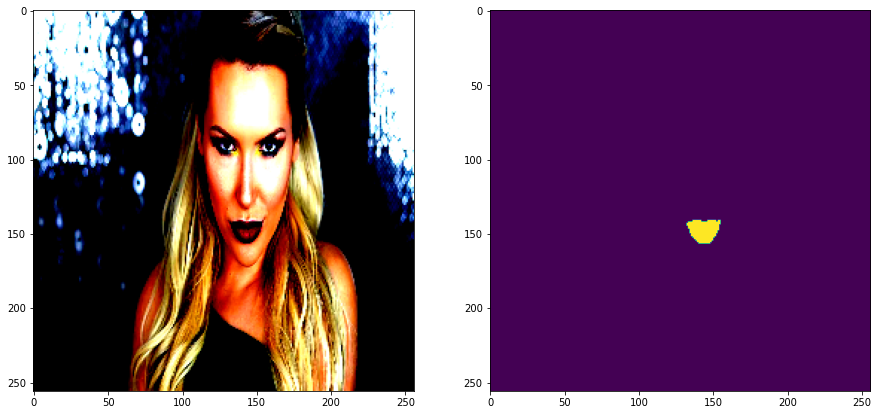

In [9]:
dataset = LipsDataset(df_images, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[:, :, 0])
plt.show()

In [10]:
X_train, X_test = train_test_split(df_images, test_size=0.3)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

In [11]:
train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False
)

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
tensor(0.) tensor(0.9961)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


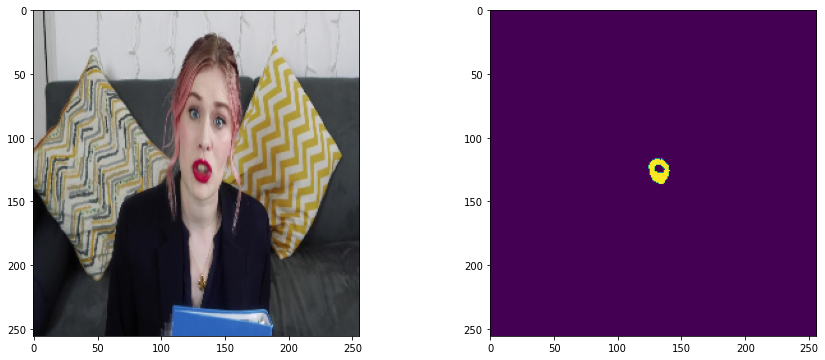

In [12]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [13]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [14]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [16]:
epoches_num = 3
max_score = 0
for i in range(epoches_num):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1071/1071 [07:25<00:00,  2.40it/s, dice_loss - 0.03357, iou_score - 0.938] 
Model saved!
Epoch: 2
valid: 100%|██████████| 1071/1071 [06:48<00:00,  2.62it/s, dice_loss - 0.02922, iou_score - 0.9444]
Model saved!
Epoch: 3
valid: 100%|██████████| 1071/1071 [06:48<00:00,  2.62it/s, dice_loss - 0.02854, iou_score - 0.9454]
Model saved!


In [18]:
data_iter = iter(train_data_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

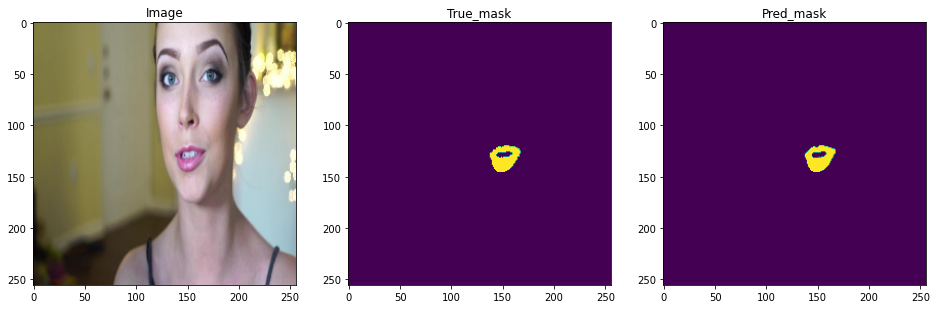

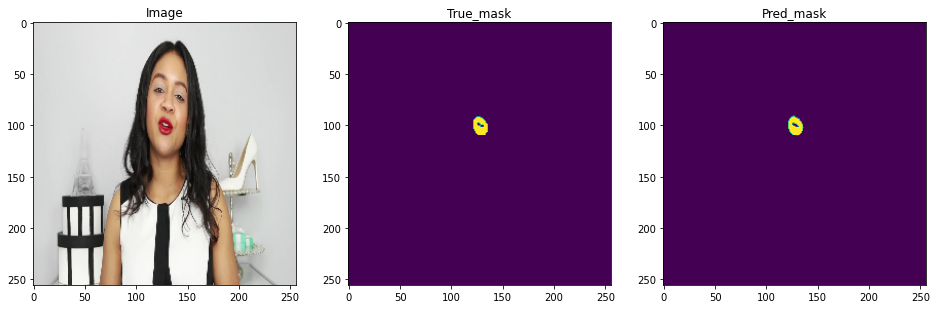

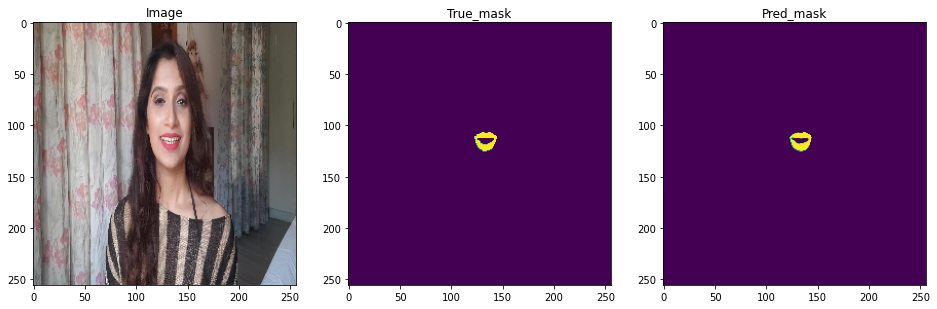

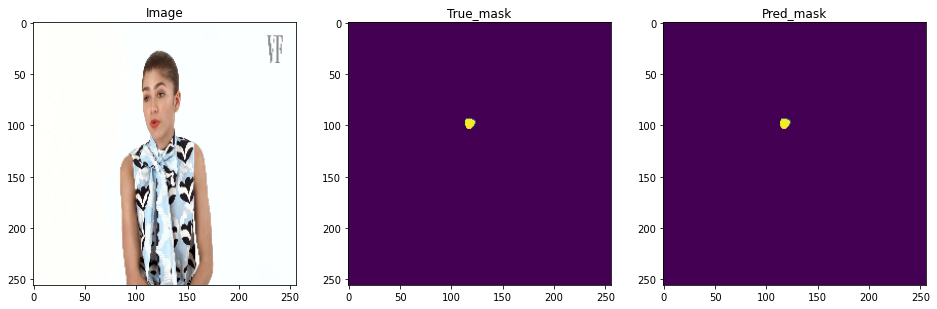

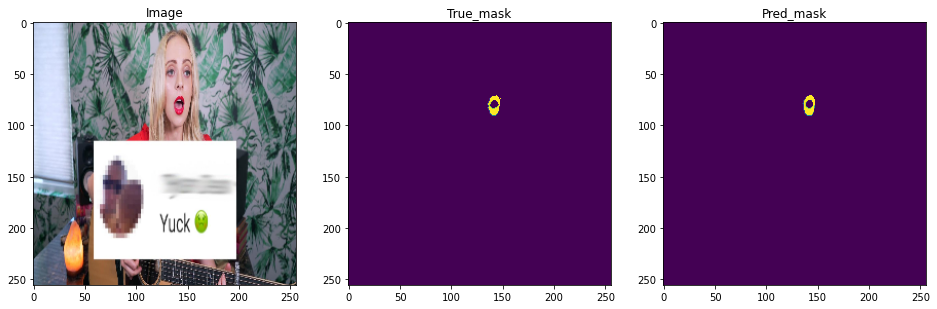

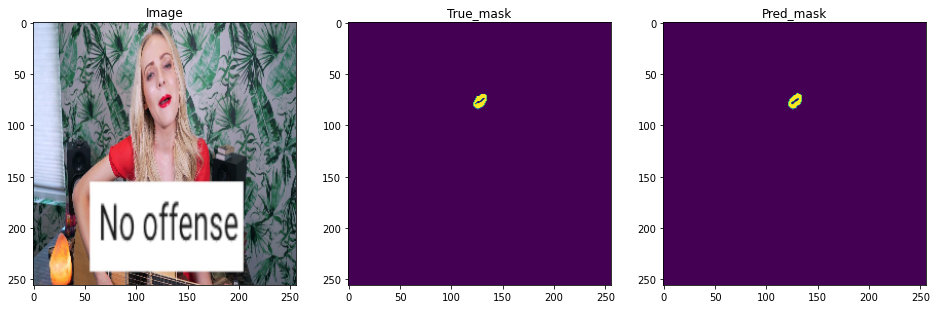

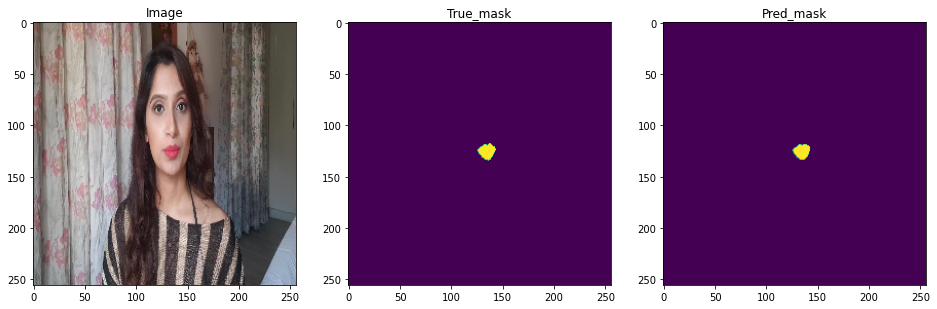

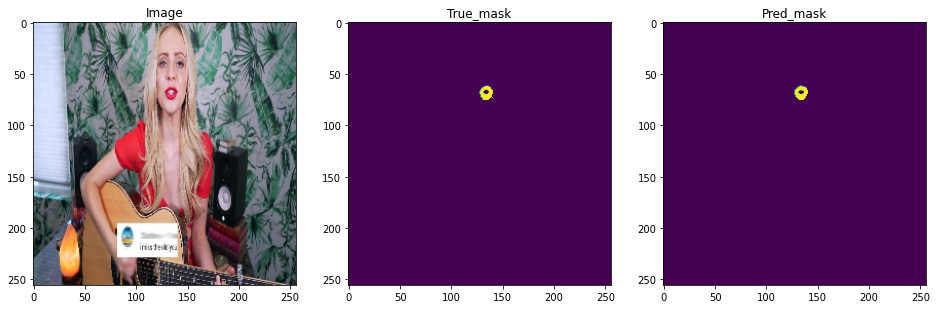

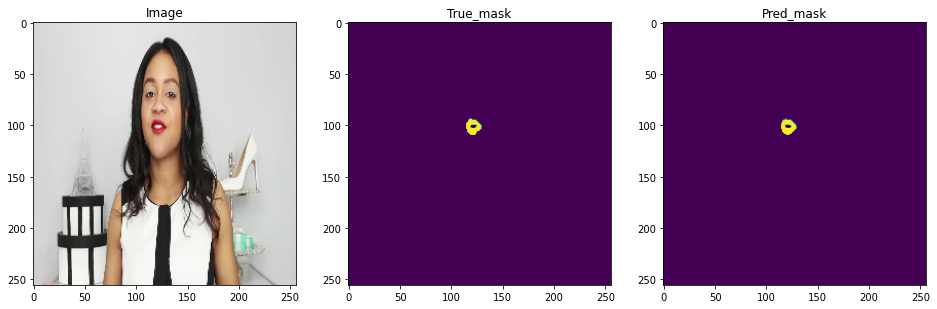

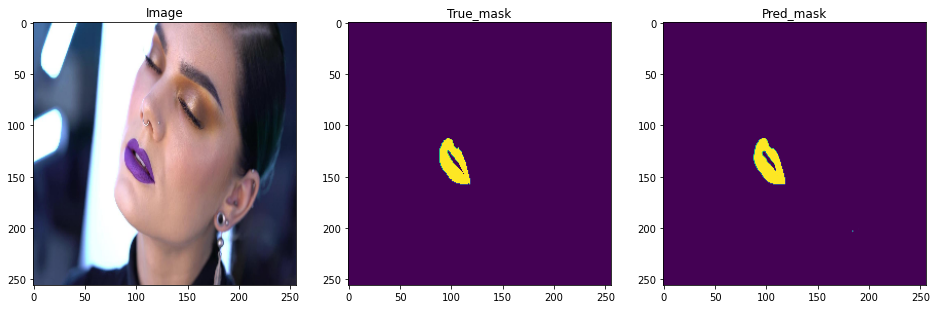

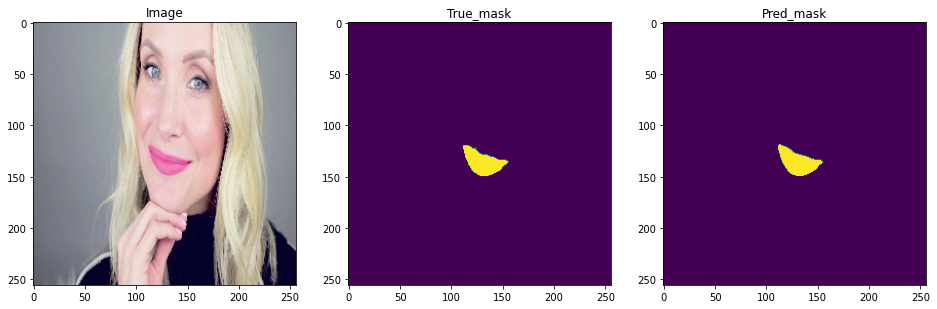

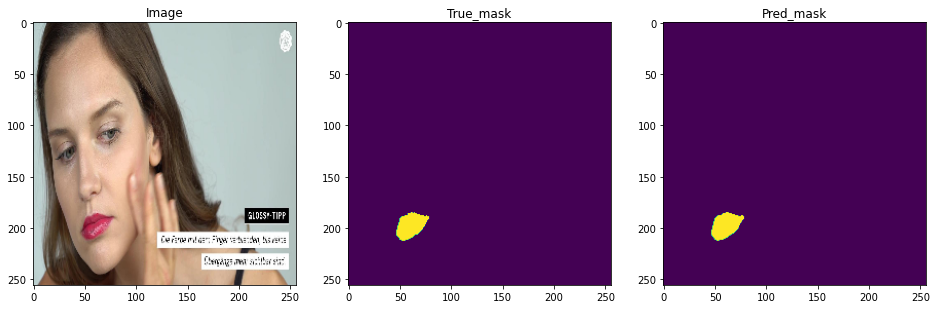

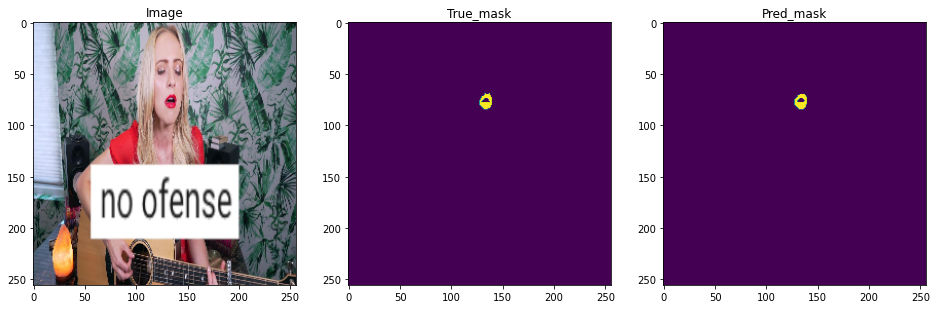

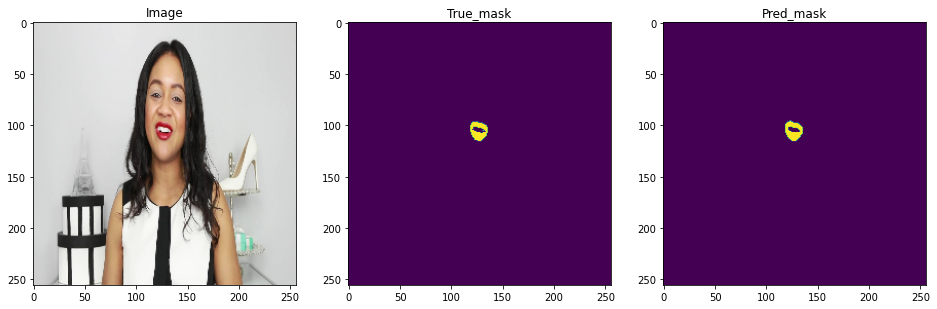

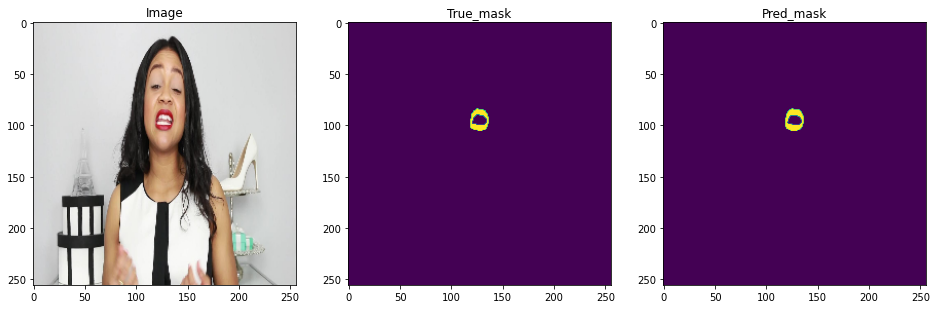

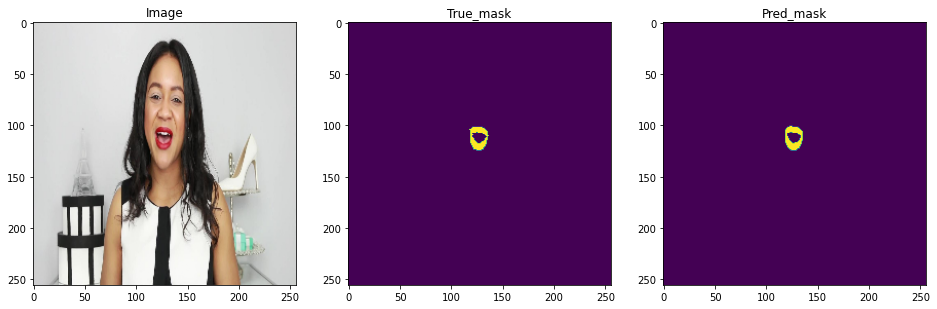

In [19]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('Pred_mask')